- TODO:
    - pad image instead of resize
    

## Imports


In [ ]:
!pip uninstall -y tensorflow estimator keras -qq
!pip install -U tensorflow_text tensorflow tensorflow_datasets -qq
!pip install einops -qq
!pip install latex -qq
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended -qq
!pip install pix2tex[train] -qq
!pip install wandb -qq
!pip install opencv-python-headless==4.1.2.30 -U -qq
!pip install --upgrade --no-cache-dir gdown -qq
!pip install --ignore-installed Pillow==9.0.0 -qq

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
import cache

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Data

In [ ]:
# Download dataset
!mkdir /content/dataset
# Dataset link: https://drive.google.com/file/d/1osUq-xbCuKjeXfU6fQTnbDliGmMmchia/view?usp=share_link
!gdown 1osUq-xbCuKjeXfU6fQTnbDliGmMmchia
!unzip -q big_handwritten.zip -d /content/dataset

Downloading...
From: https://drive.google.com/uc?id=1osUq-xbCuKjeXfU6fQTnbDliGmMmchia
To: /content/big_handwritten.zip
100% 612M/612M [00:16<00:00, 38.2MB/s]


In [ ]:
# Download sample vocab file
!wget https://raw.githubusercontent.com/UW-COSMOS/latex-ocr/master/vocab.txt
!mv vocab.txt /content/dataset

--2023-03-05 02:35:15--  https://raw.githubusercontent.com/UW-COSMOS/latex-ocr/master/vocab.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2513 (2.5K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]   2.45K  --.-KB/s    in 0s      

2023-03-05 02:35:15 (29.1 MB/s) - ‘vocab.txt’ saved [2513/2513]



In [ ]:
import os
print(len(os.listdir("dataset/images")), len(os.listdir("dataset/valimages")))

98552 1000


In [ ]:
import tensorflow as tf
IMAGE_SHAPE = (224, 224, 3)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

# read labels
with open('/content/dataset/texts.txt') as file:
    raw_label = file.read().split('\n')

with open('/content/dataset/vocab.txt') as file:
    vocab = file.read().split('\n')

In [ ]:
# standardize labels
def standardize(s):
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.
tokenizer.adapt(vocab)
tokenizer.adapt(raw_label)

tokenizer.get_vocabulary()[:10]

### Show dataset

In [ ]:
import matplotlib.pyplot as plt
import os, glob
import cv2
import random
import os

In [ ]:
!git clone https://github.com/LinXueyuanStdio/Data-for-LaTeX_OCR/

Cloning into 'Data-for-LaTeX_OCR'...
remote: Enumerating objects: 194826, done.
remote: Total 194826 (delta 0), reused 0 (delta 0), pack-reused 194826
Receiving objects: 100% (194826/194826), 1.00 GiB | 23.29 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (196616/196616), done.


In [ ]:
with open('/content/Data-for-LaTeX_OCR/fullhand/matching/train.matching.txt') as f:
    lines = f.readlines()
    f.close()
with open('/content/Data-for-LaTeX_OCR/fullhand/formulas/formulas.norm.txt') as f:
    labels_matching = f.readlines()
    f.close()

In [ ]:
plt.rcParams.update({
        "text.usetex": True,
        })

In [ ]:
def display_dataset():
    index = random.randint(0, len_data)
    img_info = lines[int(index)].strip('\n')
    image_path, label_index = img_info.split(' ')
    image_path = '/content/Data-for-LaTeX_OCR/fullhand/images/' + image_path
    label = labels_matching[int(label_index)].strip('\n')
    fig, ax = plt.subplots()
    plt.title(r'${}$'.format(label), fontsize=30)
    plt.xlabel('{}'.format(image_path), usetex=False, fontsize=20)
    width = 30
    height = 30
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches(width, height)
    img = cv2.imread(image_path)
    print('Click the image to zoom')
    plt.imshow(img)
    print("{}".format(label))

Click the image to zoom
Q = 2 \sqrt { a ( 0 ) } \sqrt { \overline { { { \eta } } } _ { 5 } ( r , \theta , \varepsilon _ { r } , \chi ) } \cos \alpha _ { 0 } ,


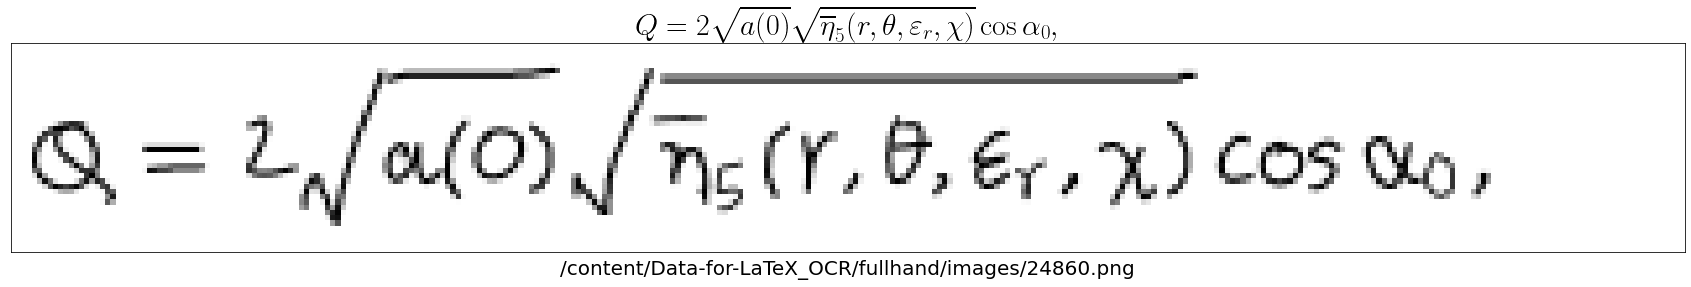

In [ ]:
with open('/content/Data-for-LaTeX_OCR/fullhand/matching/train.matching.txt') as f:
    lines = f.readlines()
    f.close()
with open('/content/Data-for-LaTeX_OCR/fullhand/formulas/formulas.norm.txt') as f:
    labels_matching = f.readlines()
    f.close()

len_data = len(lines)
display_dataset()

### Convert to TF Record dataset

### Convert to data generator

In [ ]:
def data_generator(image_paths: list, captions: list, tokenizer, max_caption_length = 150, batch_size = 16, img_size = (224, 224, 3)):
    def standardize(s):
        s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
        return s

    while True:
        indices = np.arange(len(image_paths)) # 0 -> len(images)
        np.random.shuffle(indices)
        image_paths = [image_paths[i] for i in indices]
        captions = [captions[i] for i in indices]

        # initilize inputs and outputs
        batch_images = np.zeros((batch_size, img_size[0], img_size[1], 3))
        batch_input_captions = np.zeros((batch_size, max_caption_length-1))
        batch_target_captions = np.zeros((batch_size, max_caption_length-1))

        for i in range(batch_size):
            # load image
            image = tf.keras.preprocessing.image.load_image(image_paths[i], target_size=img_size)
            image = tf.keras.preprocessing.image.img_to_array(image)
            batch_images[i] = image / 255.0

            # load caption
            caption = standardize(captions[i])
            input_caption = tokenizer(caption)[..., :-1] # except last token
            target_caption = tokenizer(caption)[..., 1:] # except first token
            input_caption = tf.keras.preprocessing.sequence.pad_sequences([input_caption], maxlen=max_caption_length-1, padding='post')[0]
            target_caption = tf.keras.preprocessing.sequence.pad_sequences([output_caption], maxlen=max_caption_length-1, padding='post')[0]
            batch_input_caption[i] = input_caption
            batch_target_captions[i] = target_caption

        yield ((batch_images, batch_caption), target_caption)

## Create model

### ViT

In [ ]:
!git clone https://github.com/protonx-engineering/vit

### Transformer

In [ ]:
!git clone https://github.com/bangoc123/transformer